In [1]:
import polars as pl

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
df = pl.read_csv("ingested.csv")
df = df.with_columns(
    (pl.col("price").ge(1000000).cast(pl.Int64).alias("ge_1M")),
    (99 - (pl.col("year_of_sale") - pl.col("built_year"))).alias("lease_remaining_during_sale")
)
display(df.sample())
print(list(df.columns))

address,lease_remaining,minimum_floor,maximum_floor,built_year,sqft,sqm,flat_type,road,town,year_of_sale,month_of_sale,months_ago,price,psf,band_name,price_is_geq_one_million,ge_1M,lease_remaining_during_sale
str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,i64,f64,str,i64,i64,i64
"""178 LOMPANG ROAD""",76,19,21,2001,1184,110,"""5 ROOM""","""LOMPANG ROAD""","""BUKIT PANJANG""",2022,8,28,778000,657.09,"""75 - 79""",0,0,78


['address', 'lease_remaining', 'minimum_floor', 'maximum_floor', 'built_year', 'sqft', 'sqm', 'flat_type', 'road', 'town', 'year_of_sale', 'month_of_sale', 'months_ago', 'price', 'psf', 'band_name', 'price_is_geq_one_million', 'ge_1M', 'lease_remaining_during_sale']


In [3]:
# Only analyse for 2024 flats.
df_filter = df.filter(
    pl.col("year_of_sale").eq(2024)
)
# Treatment
df_filter = (
    df_filter.with_columns(
        pl.col("month_of_sale").ge(8).cast(pl.Int8).alias("treatment")
    )
)
display(
    df_filter
    .group_by("treatment", "year_of_sale", "month_of_sale")
    .agg(pl.col("address").len())
    .sort("month_of_sale")
    .transpose()
)

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,0,0,0,0,0,1,1,1,1,1
2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024
1,2,3,4,5,6,7,8,9,10,11,12
2621,2123,2046,2370,2490,2171,3036,2592,2206,2146,1939,1686


In [4]:
# Features
df_filter = df_filter.with_columns(
    (pl.col("price") / pl.col("sqft")).cast(pl.Int64).alias("psf_int")
)
df_filter = df_filter.with_columns(
    ((pl.col("minimum_floor") + pl.col("maximum_floor")) / 2).cast(pl.Float32).alias("floor_proxy")
)
df_filter = df_filter.select(
    # features
    "town", "floor_proxy", "lease_remaining_during_sale", "sqm", 
    # treatment
    "treatment",
    # y
    "price", "psf_int", 
)
display(df_filter.sample(10))

town,floor_proxy,lease_remaining_during_sale,sqm,treatment,price,psf_int
str,f32,i64,i64,i8,i64,i64
"""TAMPINES""",14.0,90,113,0,935000,768
"""WOODLANDS""",8.0,78,90,0,498000,514
"""YISHUN""",8.0,93,113,1,710000,583
"""BUKIT PANJANG""",2.0,63,73,1,395888,504
"""QUEENSTOWN""",17.0,50,65,0,485000,693
"""CHOA CHU KANG""",14.0,91,93,1,600000,599
"""BUKIT BATOK""",5.0,60,84,0,465000,514
"""KALLANG/WHAMPOA""",11.0,47,68,1,480000,656
"""JURONG WEST""",11.0,59,74,1,460000,577


In [7]:
def reg(_town: str, _df: pl.DataFrame):
    # Prepare data for regression
    _X = _df.select(
        "floor_proxy",
        "lease_remaining_during_sale",
        "sqm",
        "treatment"
    ).to_pandas()
    
    _X2 = _df.select(
        "floor_proxy",
        "lease_remaining_during_sale",
        "sqm",
    ).to_pandas()
    _y = _df.select("psf_int")
    
    # Fit model
    _model = sm.OLS(_y, _X).fit(cov_type='HC1')  # Using robust standard errors
    _model2 = sm.OLS(_y, _X2).fit(cov_type='HC1')  # Using robust standard errors
    
    # Store results
    return {
        'town': _town,
        'treatment_coef': _model.params['treatment'],
        'treatment_pval': _model.pvalues['treatment'],
        'r_squared': _model.rsquared,
        'r_squared_no_treatment': _model2.rsquared,
        'n_observations': _df.shape[0],
        'effect_size': _model.params['treatment'] / _df.get_column("psf_int").std()
    }
    
os = []
for t in df_filter.select("town").unique().to_series():
    df_filter_town = df_filter.filter(
        pl.col("town").eq(t)
    )
    o = reg(t, df_filter_town)
    os.append(o)
df_o = pl.DataFrame(os)
df_o = df_o.with_columns(
    (pl.col("r_squared") - pl.col("r_squared_no_treatment")).alias("additional_explanation")
)
with pl.Config() as cfg:
    cfg.set_tbl_rows(100)
    display(df_o.sort("town"))

town,treatment_coef,treatment_pval,r_squared,r_squared_no_treatment,n_observations,effect_size,additional_explanation
str,f64,f64,f64,f64,i64,f64,f64
"""ANG MO KIO""",29.356308,2.6260e-23,0.994361,0.993826,1047,0.209611,0.000535
"""BEDOK""",31.336299,8.2248e-25,0.991979,0.991316,1290,0.315049,0.000662
"""BISHAN""",21.039435,0.003584,0.991459,0.991262,376,0.205021,0.000197
"""BUKIT BATOK""",35.856926,7.3750e-34,0.989959,0.989093,1709,0.402633,0.000866
"""BUKIT MERAH""",46.742525,2.2083e-14,0.985625,0.984783,1026,0.237008,0.000842
"""BUKIT PANJANG""",33.218825,1.1378e-16,0.98898,0.988092,854,0.448423,0.000888
"""BUKIT TIMAH""",20.228451,0.136974,0.996271,0.996121,61,0.189521,0.00015
"""CENTRAL AREA""",35.509354,0.010467,0.988711,0.988367,178,0.132742,0.000344
"""CHOA CHU KANG""",26.450636,5.2738e-24,0.992367,0.991721,1263,0.454098,0.000646


Town = ANG MO KIO


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,439.0,515.0,546.0,608.0,1067.0
1,464.0,538.0,572.0,624.0,1078.0


{'min': '5.69', 'q1': '4.47', 'median': '4.76', 'q3': '2.63', 'max': '1.03'}


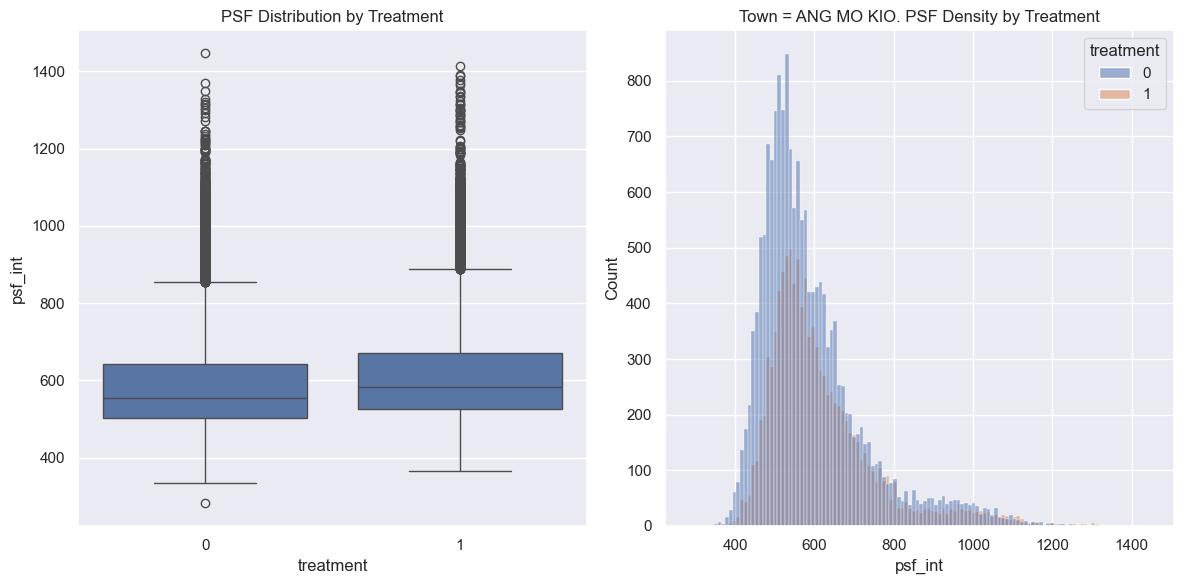

Town = BEDOK


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,409.0,505.0,541.0,603.0,940.0
1,440.0,537.0,574.0,618.0,1044.0


{'min': '7.58', 'q1': '6.34', 'median': '6.10', 'q3': '2.49', 'max': '11.06'}


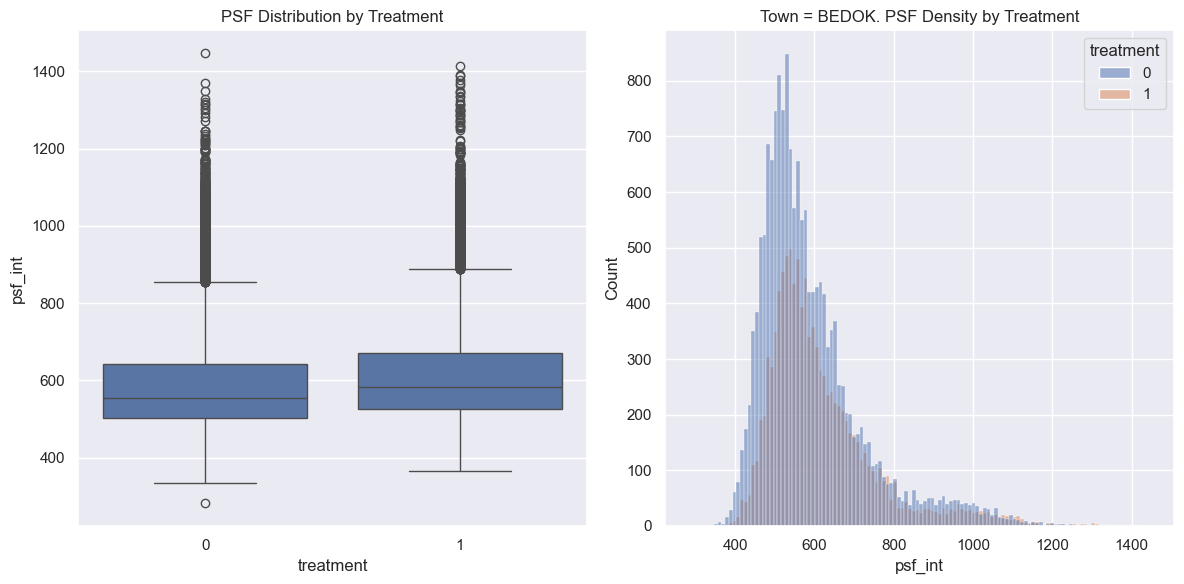

Town = BISHAN


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,453.0,665.0,714.0,764.0,1214.0
1,466.0,689.0,731.0,784.0,1192.0


{'min': '2.87', 'q1': '3.61', 'median': '2.38', 'q3': '2.62', 'max': '-1.81'}


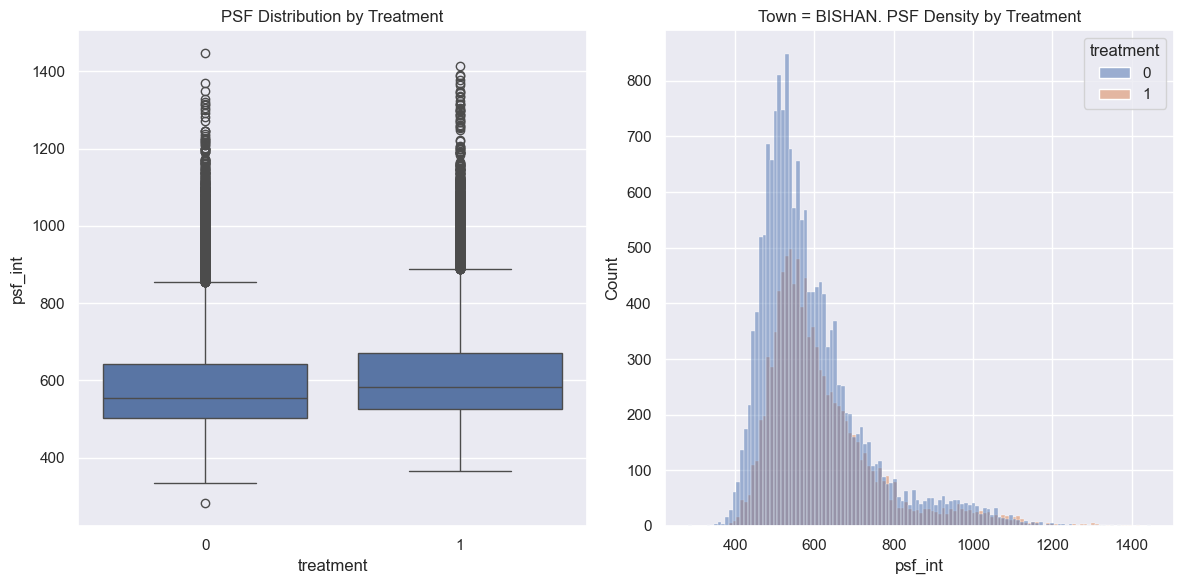

Town = BUKIT BATOK


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,281.0,509.0,585.0,646.0,954.0
1,415.0,532.0,583.0,664.0,860.0


{'min': '47.69', 'q1': '4.52', 'median': '-0.34', 'q3': '2.79', 'max': '-9.85'}


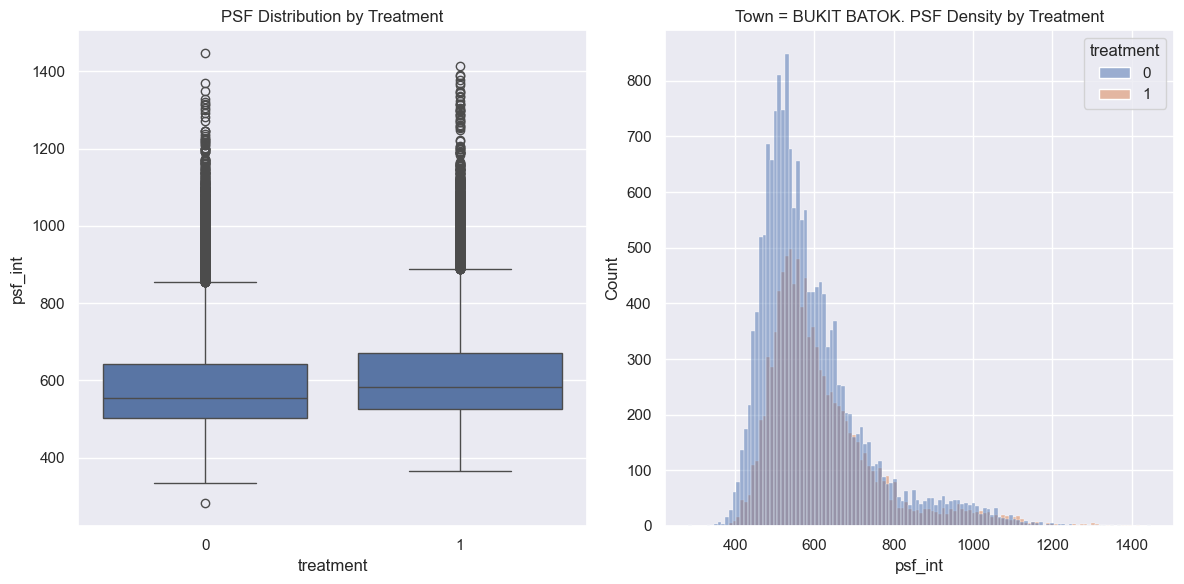

Town = BUKIT MERAH


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,432.0,579.0,799.0,929.0,1317.0
1,462.0,587.0,782.0,950.0,1333.0


{'min': '6.94', 'q1': '1.38', 'median': '-2.13', 'q3': '2.26', 'max': '1.21'}


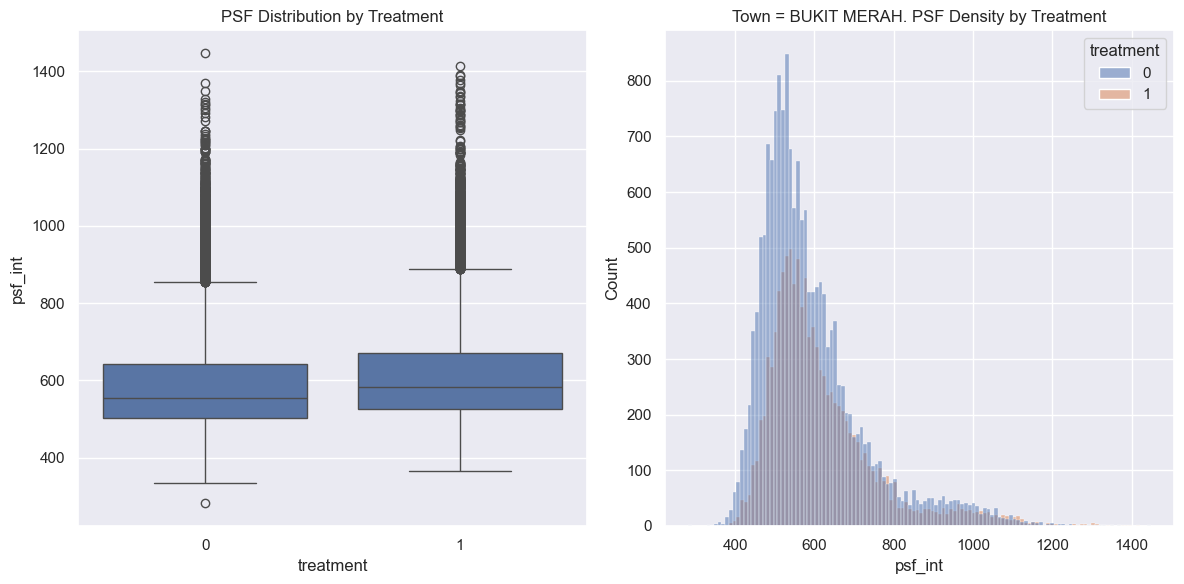

Town = BUKIT PANJANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,395.0,481.0,523.0,583.0,774.0
1,417.0,501.0,552.0,606.0,816.0


{'min': '5.57', 'q1': '4.16', 'median': '5.54', 'q3': '3.95', 'max': '5.43'}


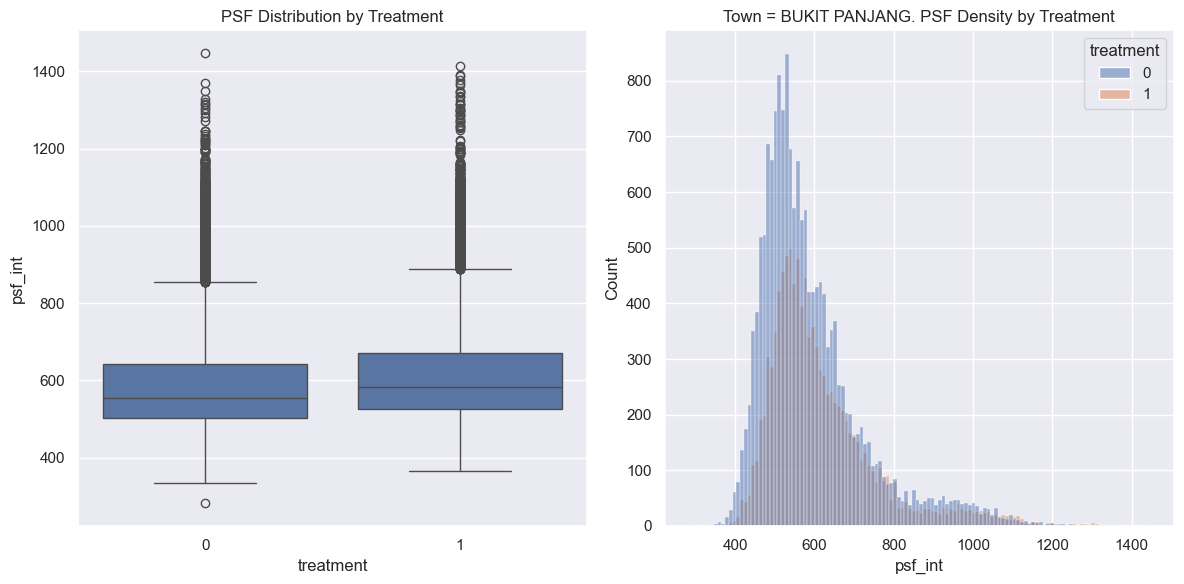

Town = BUKIT TIMAH


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,526.0,635.0,748.0,804.0,898.0
1,561.0,686.0,768.0,837.0,942.0


{'min': '6.65', 'q1': '8.03', 'median': '2.67', 'q3': '4.10', 'max': '4.90'}


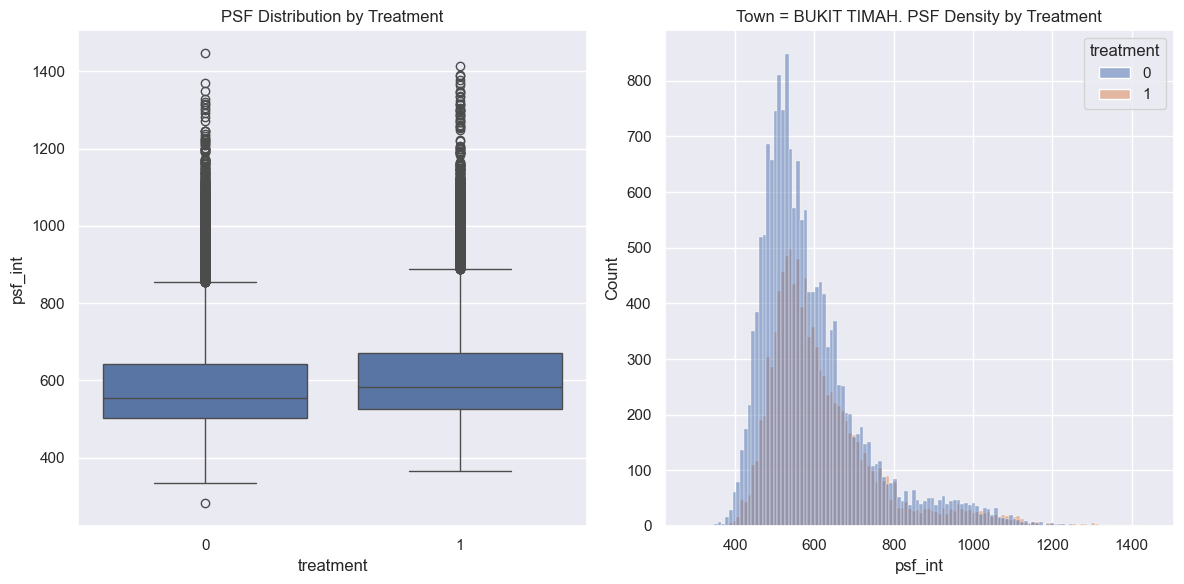

Town = CENTRAL AREA


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,495.0,639.0,722.0,821.0,1448.0
1,547.0,682.0,818.0,1286.0,1414.0


{'min': '10.51', 'q1': '6.73', 'median': '13.30', 'q3': '56.64', 'max': '-2.35'}


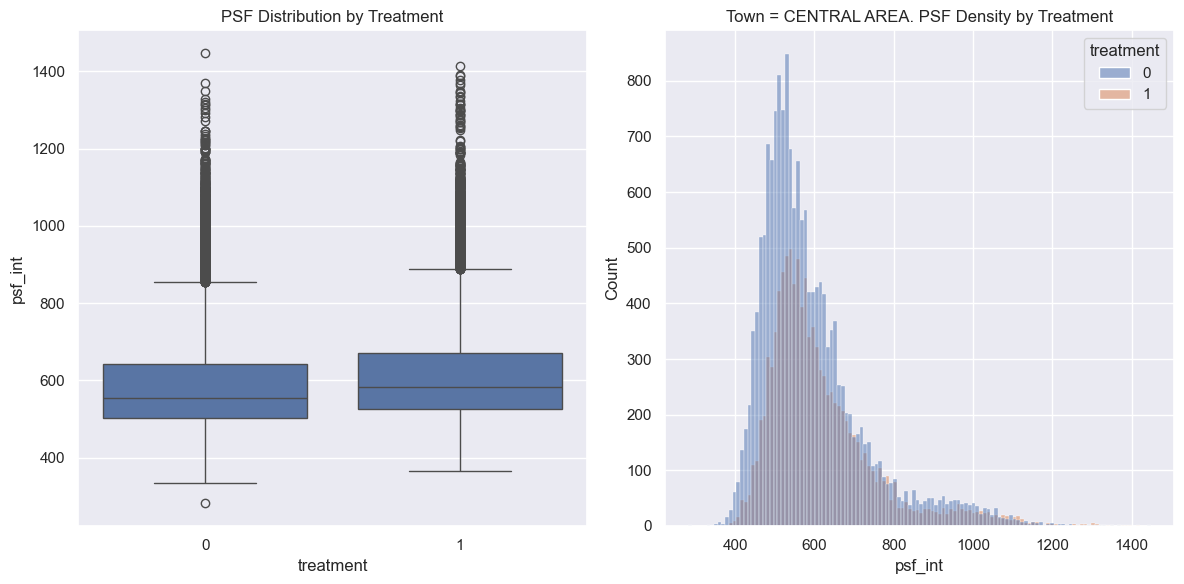

Town = CHOA CHU KANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,367.0,446.0,475.0,520.0,664.0
1,403.0,473.0,504.0,552.0,697.0


{'min': '9.81', 'q1': '6.05', 'median': '6.11', 'q3': '6.15', 'max': '4.97'}


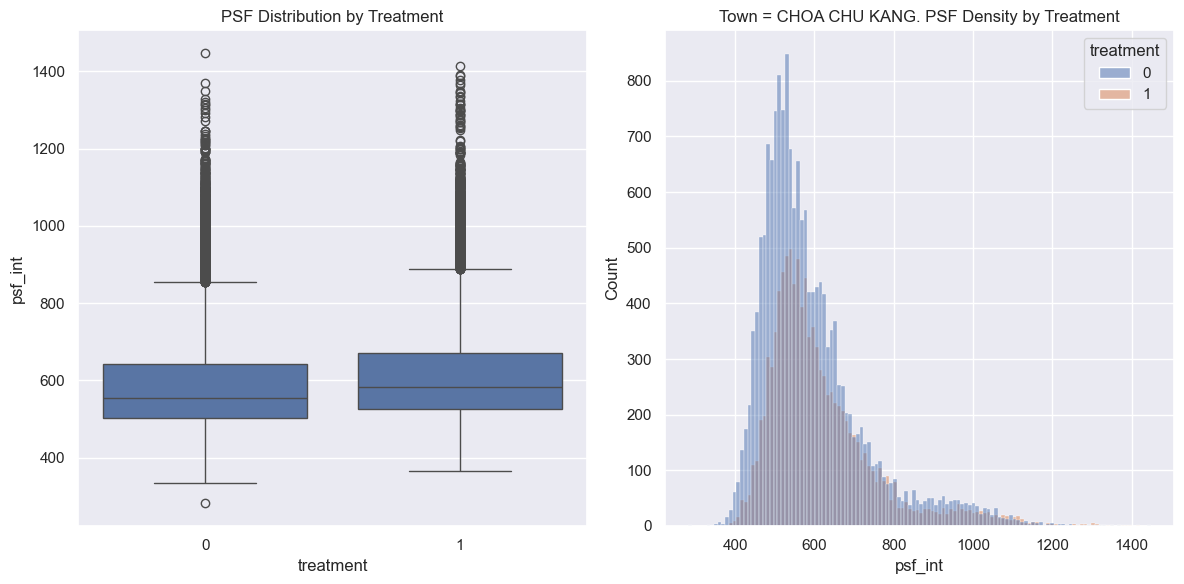

Town = CLEMENTI


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,377.0,513.0,564.0,808.0,1156.0
1,454.0,533.0,590.0,710.0,1194.0


{'min': '20.42', 'q1': '3.90', 'median': '4.61', 'q3': '-12.13', 'max': '3.29'}


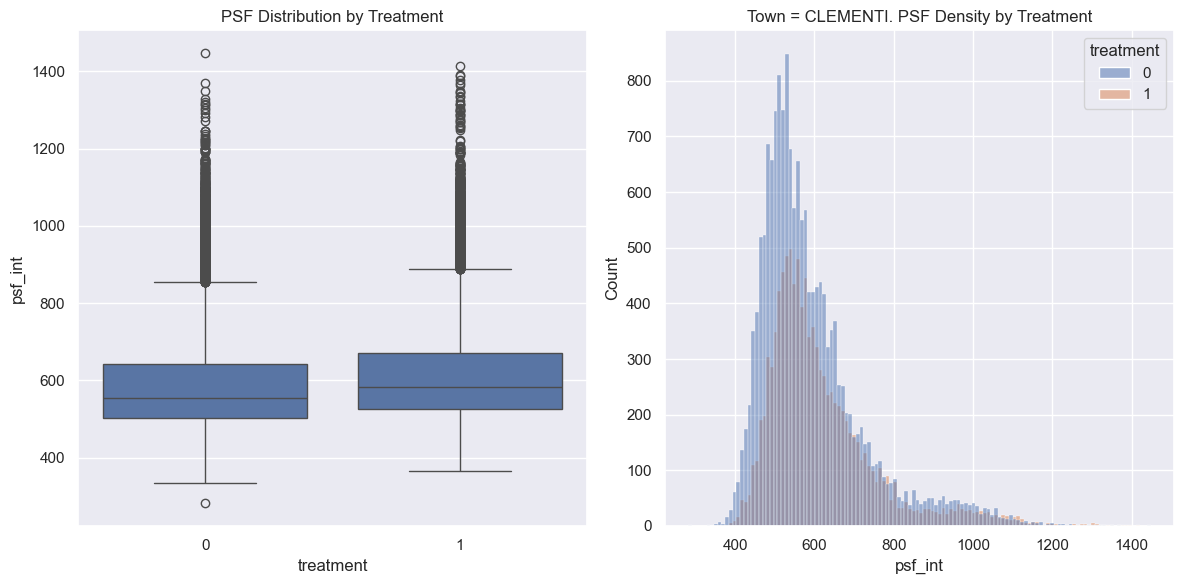

Town = GEYLANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,416.0,529.0,581.0,804.0,1078.0
1,371.0,561.0,636.0,945.0,1080.0


{'min': '-10.82', 'q1': '6.05', 'median': '9.47', 'q3': '17.54', 'max': '0.19'}


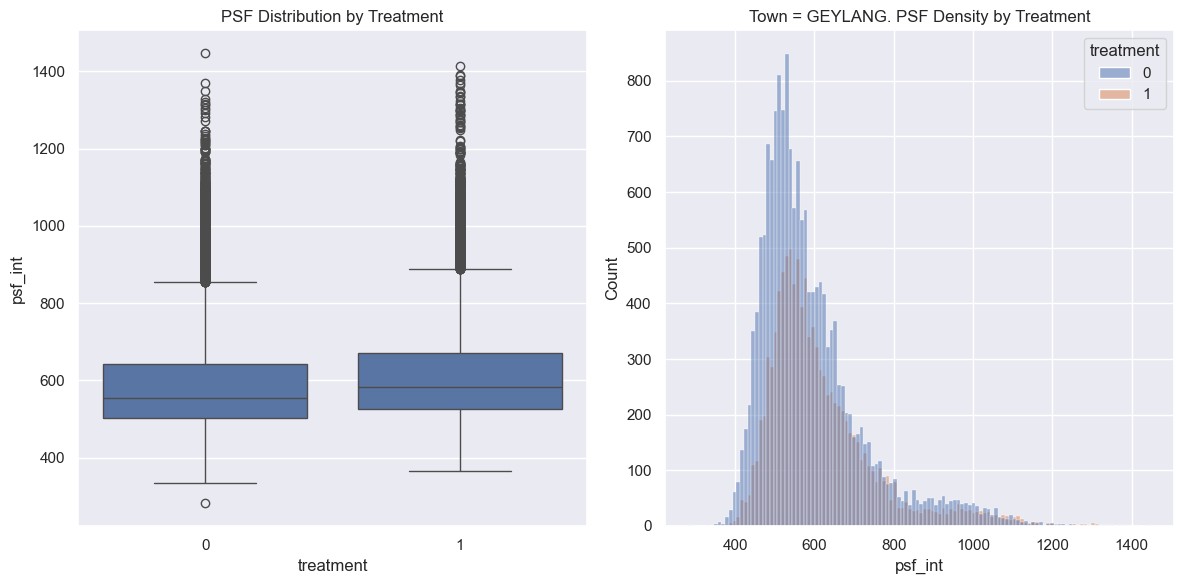

Town = HOUGANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,426.0,518.0,562.0,624.0,843.0
1,460.0,549.0,588.0,640.0,847.0


{'min': '7.98', 'q1': '5.98', 'median': '4.63', 'q3': '2.56', 'max': '0.47'}


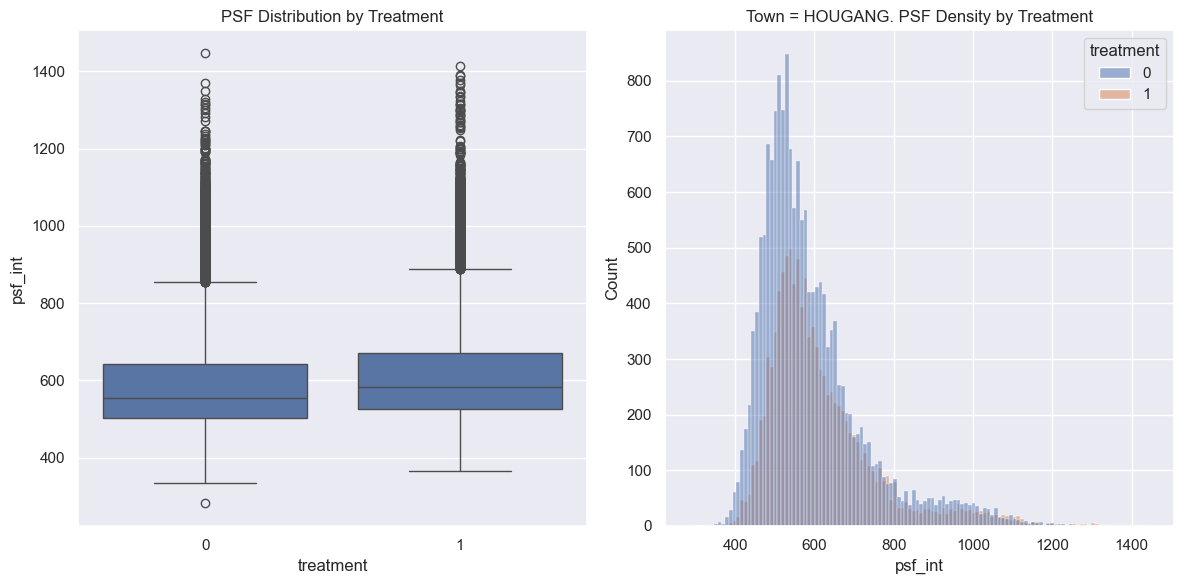

Town = JURONG EAST


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,352.0,459.0,501.0,543.0,741.0
1,390.0,489.0,533.0,578.0,772.0


{'min': '10.80', 'q1': '6.54', 'median': '6.39', 'q3': '6.45', 'max': '4.18'}


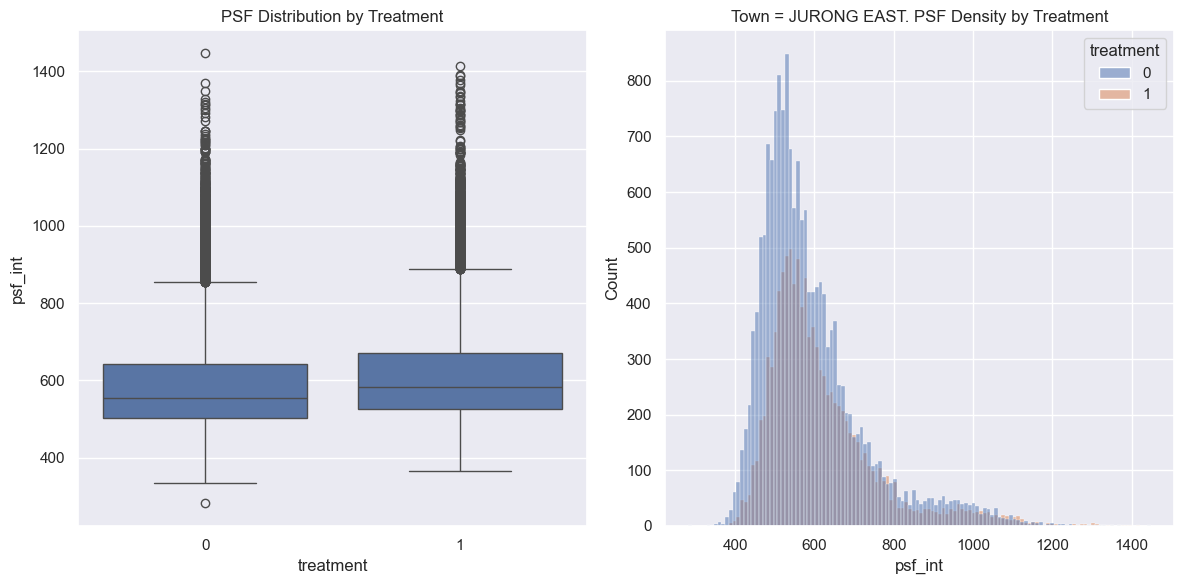

Town = JURONG WEST


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,360.0,440.0,484.0,533.0,806.0
1,379.0,456.0,506.0,557.0,863.0


{'min': '5.28', 'q1': '3.64', 'median': '4.55', 'q3': '4.50', 'max': '7.07'}


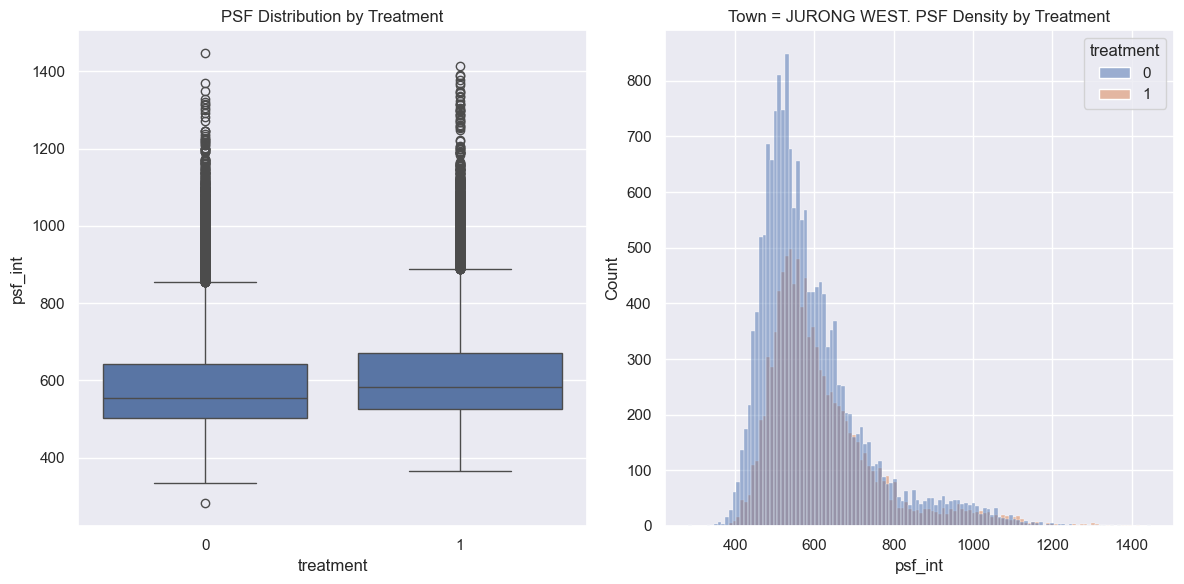

Town = KALLANG/WHAMPOA


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,357.0,564.0,672.0,917.0,1191.0
1,376.0,577.0,690.0,952.0,1262.0


{'min': '5.32', 'q1': '2.30', 'median': '2.68', 'q3': '3.82', 'max': '5.96'}


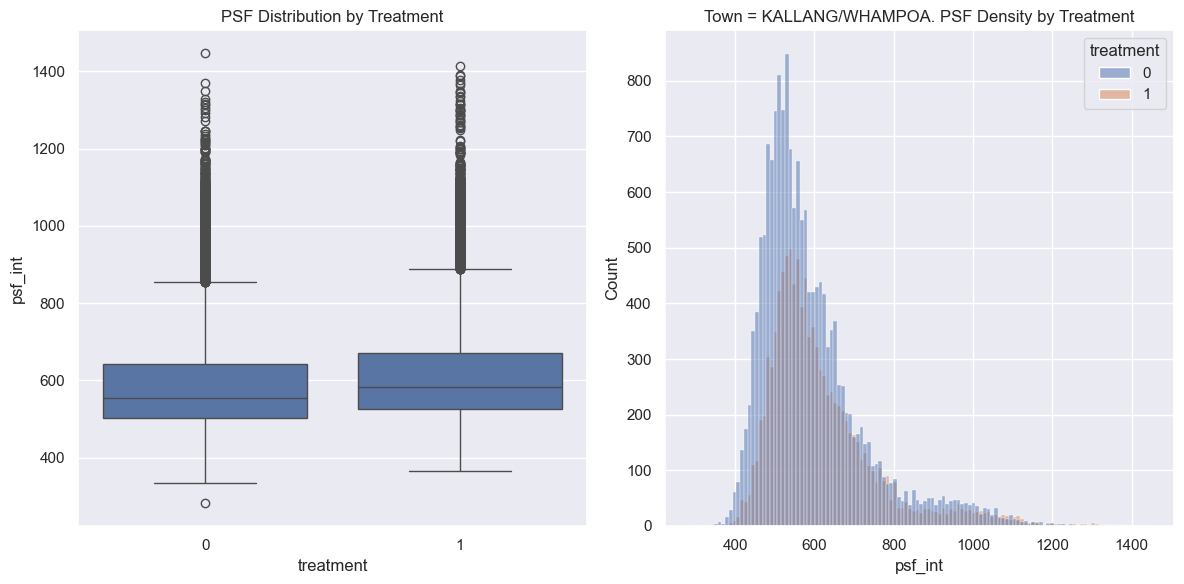

Town = MARINE PARADE


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,496.0,583.0,619.0,681.0,856.0
1,520.0,622.0,643.0,697.0,806.0


{'min': '4.84', 'q1': '6.69', 'median': '3.88', 'q3': '2.35', 'max': '-5.84'}


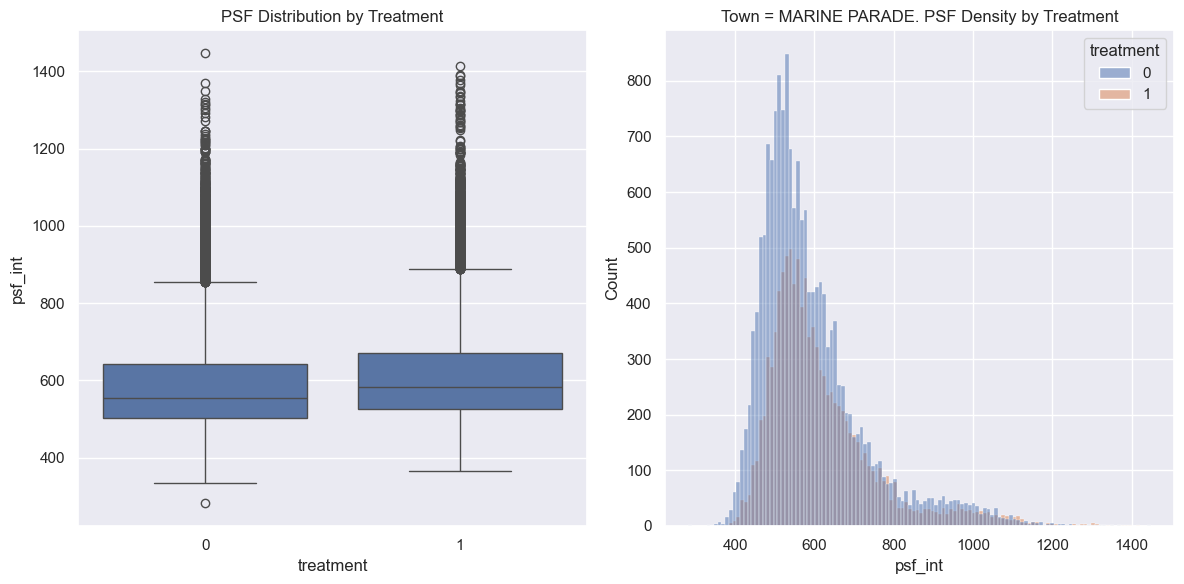

Town = PASIR RIS


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,443.0,495.0,520.0,553.0,920.0
1,468.0,514.0,536.0,564.0,913.0


{'min': '5.64', 'q1': '3.84', 'median': '3.08', 'q3': '1.99', 'max': '-0.76'}


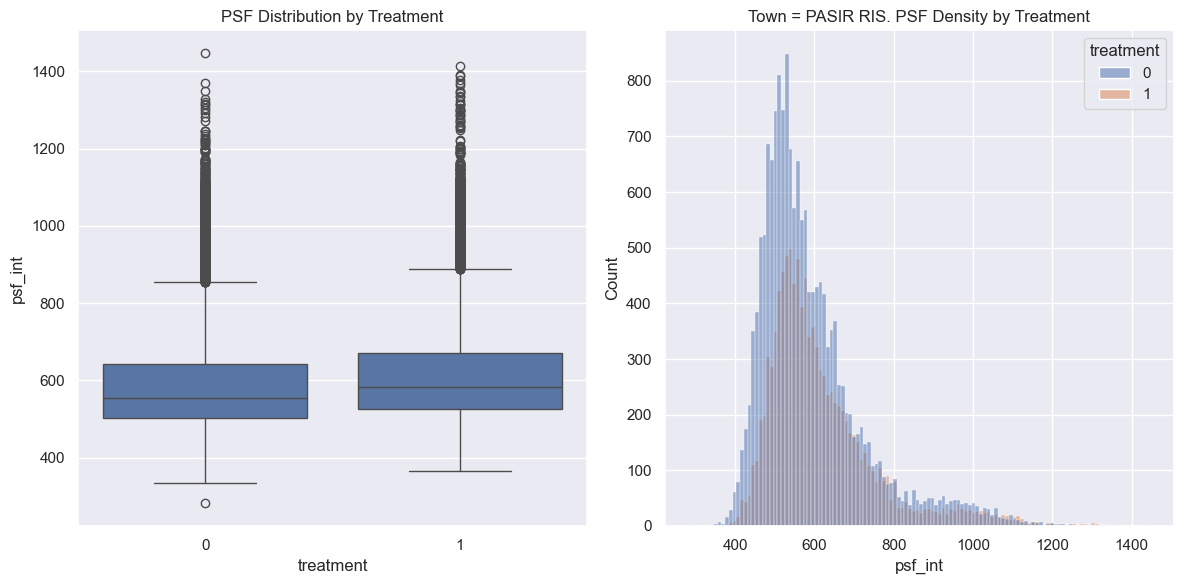

Town = PUNGGOL


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,445.0,588.0,637.0,681.0,894.0
1,464.0,599.0,659.0,703.0,855.0


{'min': '4.27', 'q1': '1.87', 'median': '3.45', 'q3': '3.23', 'max': '-4.36'}


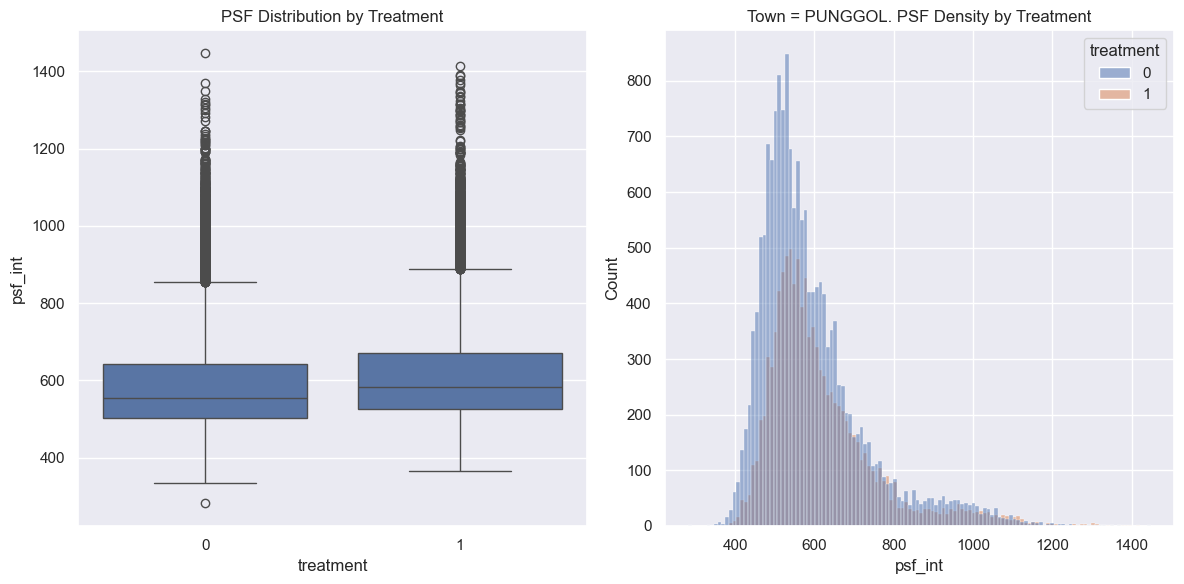

Town = QUEENSTOWN


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,417.0,557.0,726.0,944.0,1245.0
1,438.0,572.0,729.0,958.0,1350.0


{'min': '5.04', 'q1': '2.69', 'median': '0.41', 'q3': '1.48', 'max': '8.43'}


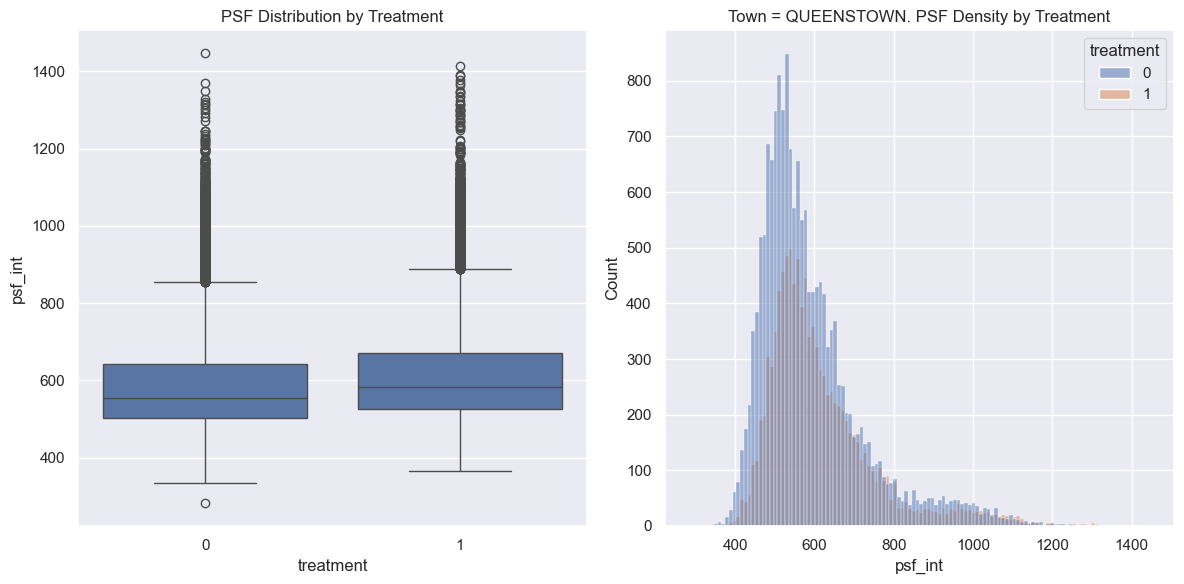

Town = SEMBAWANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,409.0,494.0,558.0,619.0,867.0
1,447.0,532.0,600.0,686.0,941.0


{'min': '9.29', 'q1': '7.69', 'median': '7.53', 'q3': '10.82', 'max': '8.54'}


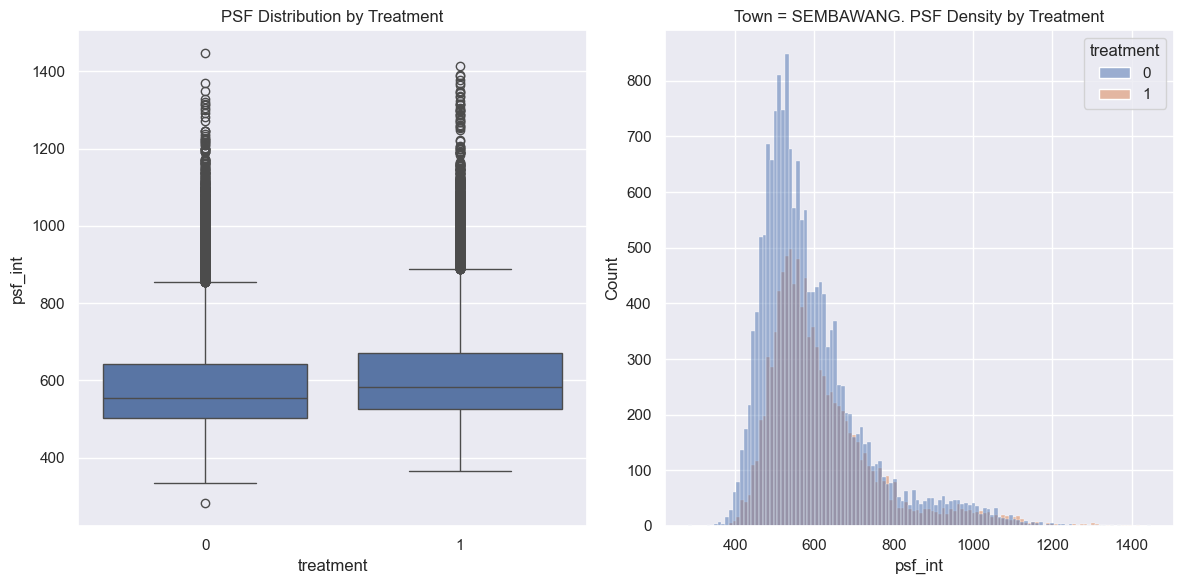

Town = SENGKANG


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,423.0,525.0,580.0,639.0,858.0
1,456.0,560.0,623.0,677.0,929.0


{'min': '7.80', 'q1': '6.67', 'median': '7.41', 'q3': '5.95', 'max': '8.28'}


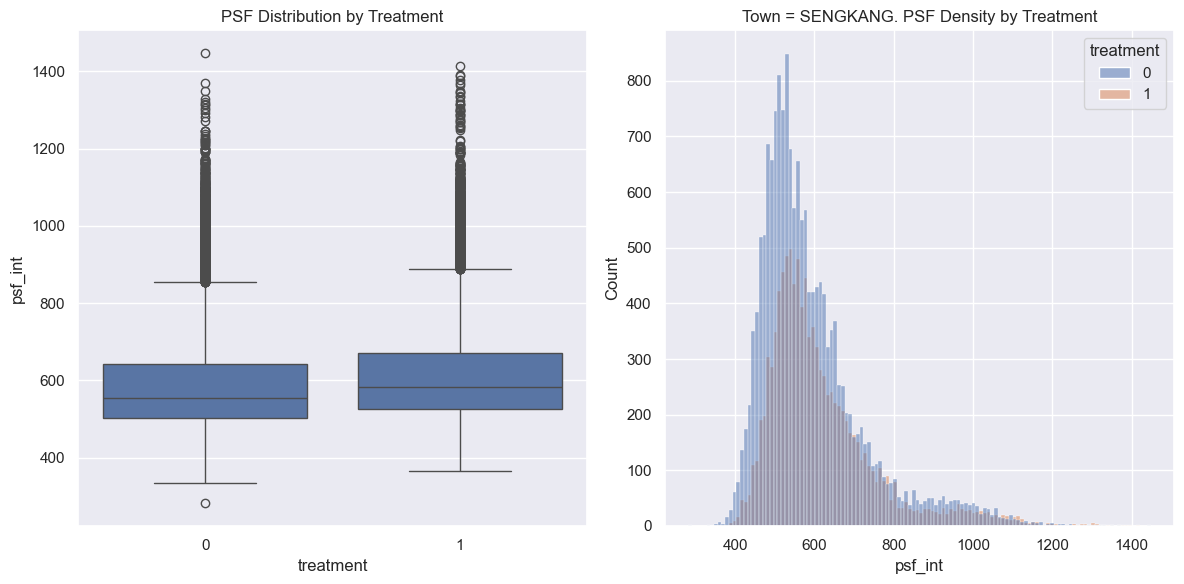

Town = SERANGOON


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,436.0,551.0,602.0,670.0,822.0
1,495.0,577.0,623.0,686.0,815.0


{'min': '13.53', 'q1': '4.72', 'median': '3.49', 'q3': '2.39', 'max': '-0.85'}


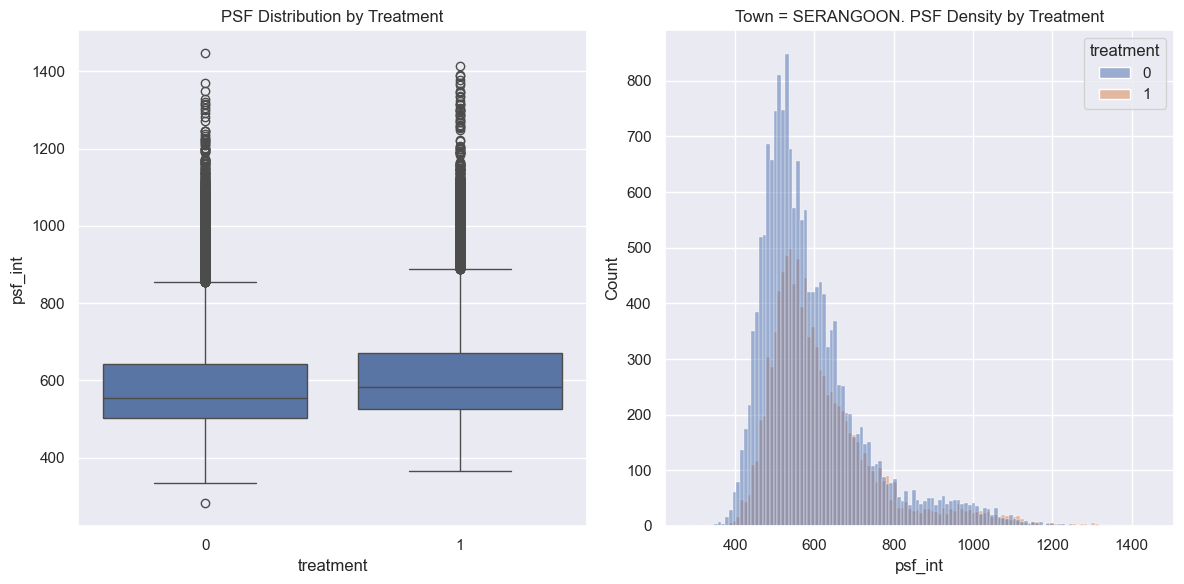

Town = TAMPINES


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,418.0,526.0,563.0,684.0,935.0
1,442.0,548.0,590.0,719.0,985.0


{'min': '5.74', 'q1': '4.18', 'median': '4.80', 'q3': '5.12', 'max': '5.35'}


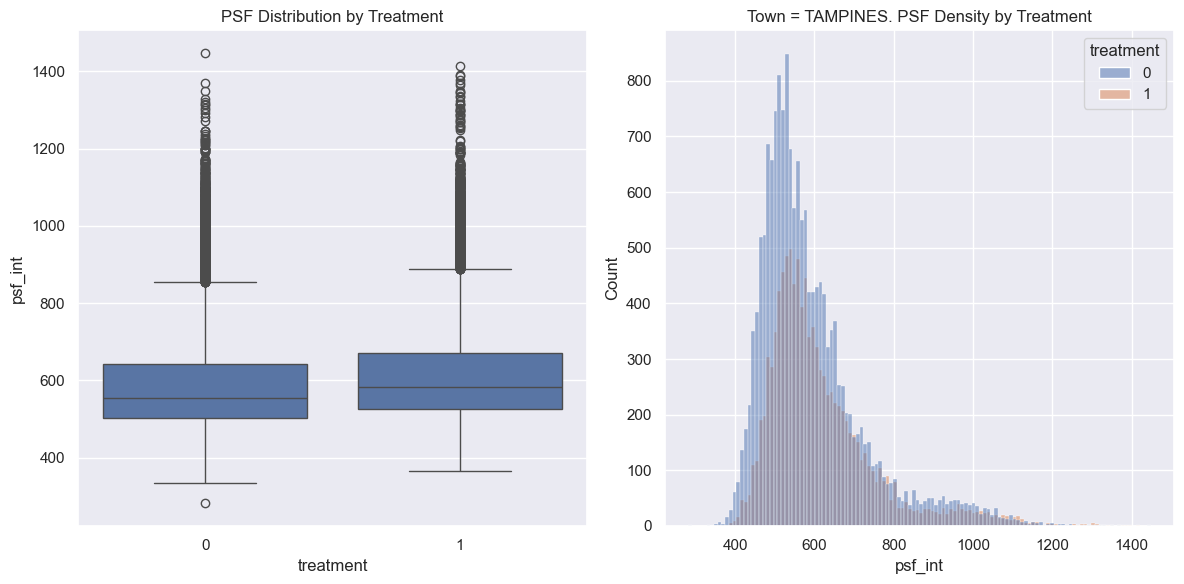

Town = TOA PAYOH


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,429.0,518.0,593.0,911.0,1246.0
1,440.0,539.0,642.0,967.0,1222.0


{'min': '2.56', 'q1': '4.05', 'median': '8.26', 'q3': '6.15', 'max': '-1.93'}


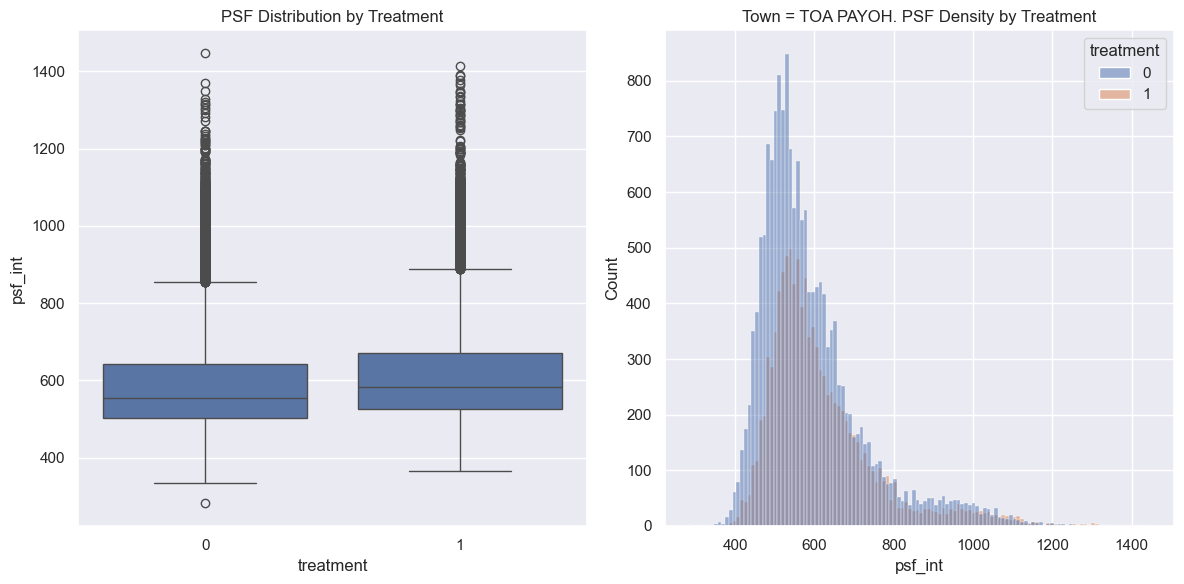

Town = WOODLANDS


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,334.0,469.0,501.0,554.0,904.0
1,366.0,488.0,518.0,560.0,929.0


{'min': '9.58', 'q1': '4.05', 'median': '3.39', 'q3': '1.08', 'max': '2.77'}


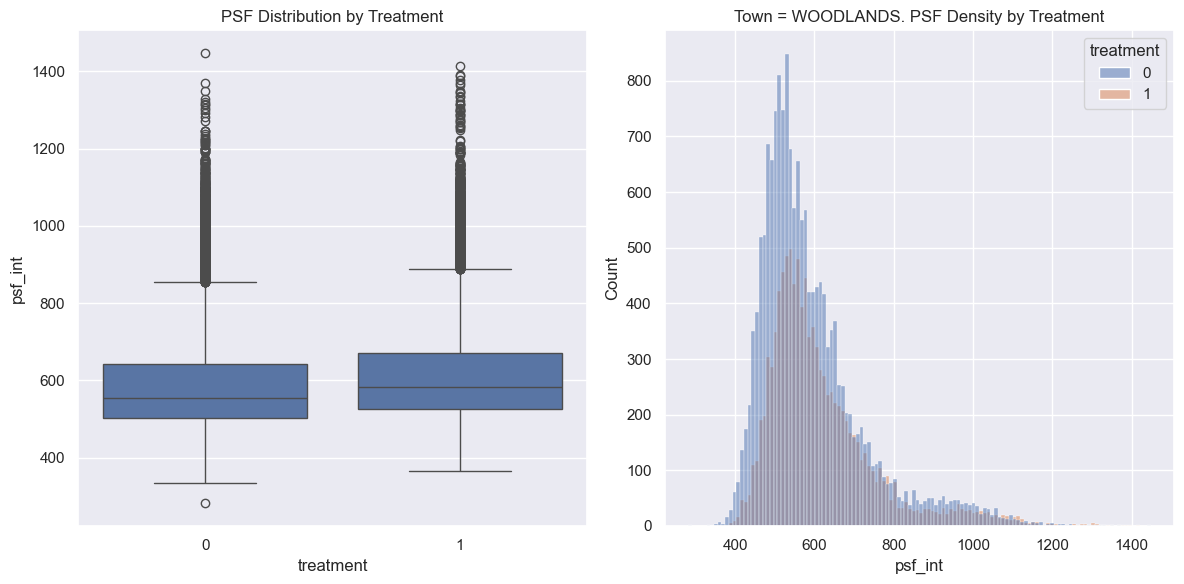

Town = YISHUN


treatment,min,q1,median,q3,max
i8,f64,f64,f64,f64,f64
0,402.0,501.0,539.0,579.0,831.0
1,420.0,518.0,555.0,602.0,808.0


{'min': '4.48', 'q1': '3.39', 'median': '2.97', 'q3': '3.97', 'max': '-2.77'}


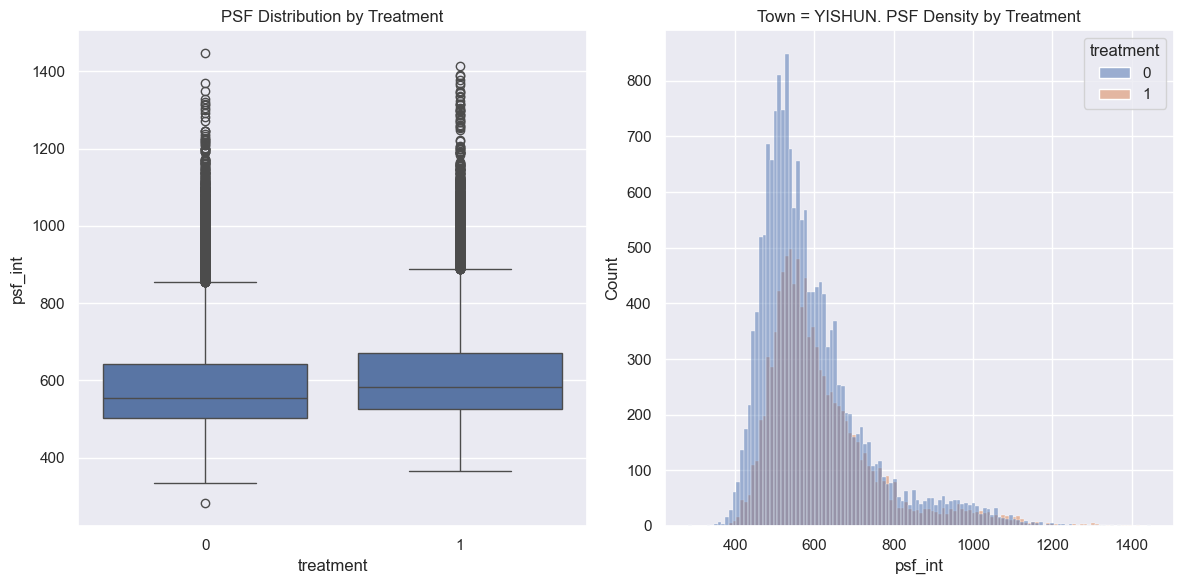

In [6]:
def _plot(_t: str, _df: pl.DataFrame):
    summary = (
        _df.group_by("treatment")
        .agg(
            pl.col("psf_int").quantile(0.0).alias("min"),
            pl.col("psf_int").quantile(0.25).alias("q1"),
            pl.col("psf_int").quantile(0.50).alias("median"),
            pl.col("psf_int").quantile(0.75).alias("q3"),
            pl.col("psf_int").quantile(1.0).alias("max"),
        )
    )
    print(f"Town = {_t}")
    display(summary.sort("treatment"))
    # Calculate percentage differences
    control = summary.filter(pl.col("treatment") == 0)
    treatment = summary.filter(pl.col("treatment") == 1)
    
    pct_diff = {
        metric: f"{(((treatment.get_column(metric)[0] - control.get_column(metric)[0]) / control.get_column(metric)[0] * 100)):.2f}"
        for metric in ["min", "q1", "median", "q3", "max"]
    }
    print(pct_diff)
    plt.figure(figsize=(12, 6))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_filter.to_pandas(), x="treatment", y="psf_int")
    plt.title("PSF Distribution by Treatment")

    # Density plot
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_filter.to_pandas(), x="psf_int", hue="treatment")
    plt.title(f"Town = {_t}. PSF Density by Treatment")

    plt.tight_layout()
    plt.show()

for t in sorted(df_filter.select("town").unique().to_series()):
    df_filter_town = df_filter.filter(
        pl.col("town").eq(t)
    )
    _plot(t, df_filter_town)